<font size="6">**DSCI 100 group 24 project proposal**</font>
<br>
<br><font size="4">**Introduction:**</font>
<br>
<br>Heart disease is a serious issue affecting many people worldwide. Many factors can put people at risk of having heart disease such as cholesterol, blood pressure, and age.
In this study, we will be exploring and predicting if a person has heart disease given their attributes such as gender, age, serum cholesterol etc. 
We will be trying to answer the question:  “Are age, chest pain type, resting blood pressure, cholesterol and maximum heart rate predictors of heart disease?”
In our project, we will be using the heart disease data set for cleveland, which contains 14 different attributes:
1. Age (in years)
2. Sex (1 = male; 0 = female)
3. cp: chest pain type (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic)
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol: serum cholesterol in mg/dl
6. fbs: fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
7. restecg: resting electrocardiographic results (0 = normal, 1 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
8. Thalach: maximum heart rate achieved
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak: ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment (1 = upsloping, 2 = flat, 3 = downsloping)
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
14. num: diagnosis of heart disease (angiographic disease status) (0 = < 50% diameter narrowing, 1 = > 50% diameter narrowing)


In [1]:
#These are the packages we will use for analyzing our dataset:
library(tidyverse)
library(tidymodels)
library(repr)
library(digest)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

<font size="4">**Preliminary exploratory data analysis:**</font>

In [2]:
data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names=c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num"))

data_mutated = data |>
mutate(heart_disease = case_when(num == 0 ~ "absent",
                                 num == 1 ~ "presence",
                                 num == 2 ~ "presence",
                                 num == 3 ~ "presence"))

data_mutated

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,absent
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,presence
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,presence
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3,presence
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1,presence
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0,absent


In [3]:
#Using only training data, summarize the data in at least one table (this is exploratory data analysis). 
#An example of a useful table could be one that reports the number of observations in each class, the means of the 
#predictor variables you plan to use in your analysis and how many rows have missing data. 
#Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do 
#(this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the
#predictor variables you plan to use in your analysis.

In [4]:
data_training <- initial_split(data_mutated, prop = .75, strata= age)  
data_training <- training(data_training)
data_training

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,absent
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,absent
44,1,2,120,263,0,0,173,0,0.0,1,0.0,7.0,0,absent
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
63,1,4,140,187,0,2,144,1,4.0,1,2.0,7.0,2,presence
63,0,4,124,197,0,0,136,1,0.0,2,0.0,3.0,1,presence
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2,presence


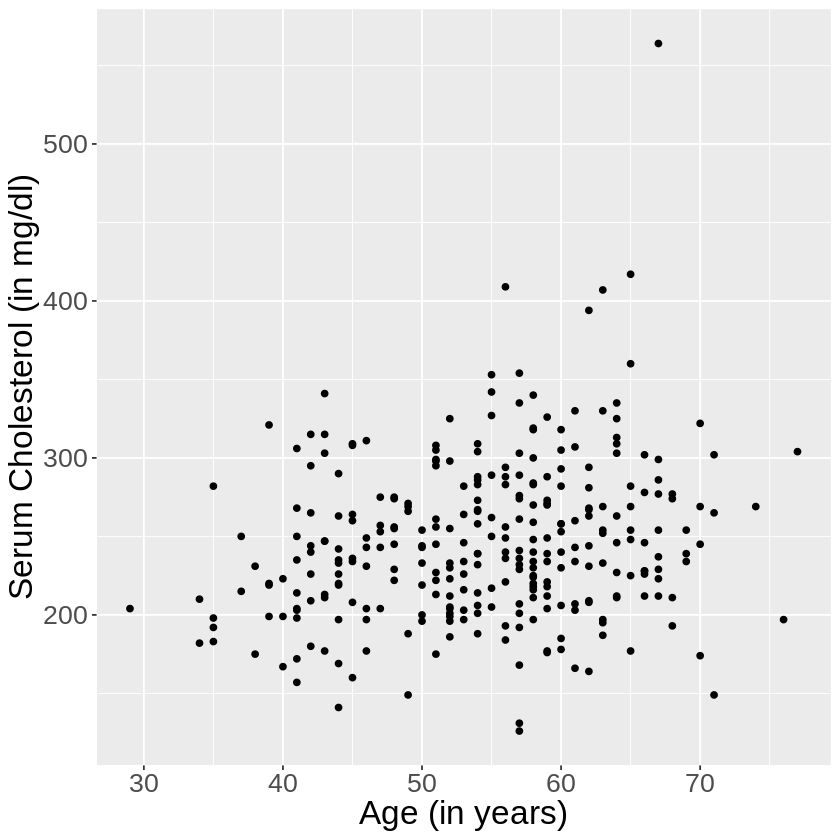

In [5]:
data_plot<- data_mutated|>
    ggplot(aes(x = age, y = chol))+
        geom_point() +
        xlab("Age (in years)") +
        ylab("Serum Cholesterol (in mg/dl)")+
        theme(text = element_text(size=20))
data_plot

<font size="4">**Methods:**</font>
<br>
<br> We plan to mutate the data so that 0= no heart disease, any other number = heart disease. We will use classification to predict whether or not age, chest pain type, resting blood pressure, cholesterol and maximum heart rate are predictors of heart disease. The variables we will use will be  age (in years), sex: sex (1 = male; 0 = female), painloc: chest pain location (1 = substernal; 0 = otherwise),cp: chest pain type (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic), trestbps: resting blood pressure (in mm Hg on admission to the hospital), chol: serum cholesterol in mg/dl,smoke: I believe this is 1 = yes; 0 = no (is or is not a smoker), cigs (cigarettes per day), years (number of years as a smoker). We will use the scatterplot to veiw our results.


<font size="4">**Expected outcomes and significance:**</font>
<br>
<br> We are expecting to find which variable has the most influence on getting a heart disease.
By distinguishing the variable, we can target the specific area and get treatment for it.
Narrowing it down to see how a single variable affects the chance of getting heart disease? Does gender affect chances of getting heart disease?

<font size="4">**Reference:**</font>
<br>
<br> Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.